In [1]:
#%pip install -q -U tensorboard-plugin-profile
#%pip install -q -U keras-tuner
import numpy as np
import keras_tuner as kt
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
root_logdir = os.path.join(os.curdir, "hyperband_logs")
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [3]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test
/ 255.
print(X_train.shape)
print(X_train.dtype)

(55000, 28, 28)
float64


In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
def model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256, step=16)
    learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-2, sampling="log")
    optimizer_choice = hp.Choice("optimizer", values=["sgd", "adam"])
    
    if optimizer_choice == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=[28, 28]))  
    model.add(tf.keras.layers.Flatten())      
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    return model

class MyClassificationHyperModel(kt.HyperModel):
     def build(self, hp):
         return model(hp)
     def fit(self, hp, model, X, y, **kwargs):
         if hp.Boolean("normalize"):
             norm_layer = tf.keras.layers.Normalization()
             X = norm_layer(X)
         return model.fit(X, y, **kwargs)

In [6]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

In [7]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(),
    objective="val_accuracy",
    max_epochs=100,
    factor=3,
    overwrite=False,
    directory="my_fashion_mnist",
    project_name="classification_hyperband",
    seed=60
)

Reloading Tuner from my_fashion_mnist\classification_hyperband\tuner0.json


In [8]:
hyperband_tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb, early_stopping_cb]
)

Trial 254 Complete [00h 06m 44s]
val_accuracy: 0.8640000224113464

Best val_accuracy So Far: 0.9010000228881836
Total elapsed time: 1d 03h 11m 10s


In [9]:
MLP = hyperband_tuner.get_best_models(num_models=1)[0]
best_hyperparameters = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hyperparameters.values)


C:\Users\marce\anaconda4\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters: {'n_hidden': 5, 'n_neurons': 224, 'learning_rate': 0.0004596654909836297, 'optimizer': 'adam', 'normalize': False, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0203'}


In [10]:
MLP.fit(
    X_train_full, y_train_full,
    epochs=100,
    callbacks=[tensorboard_cb]
)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.9370 - loss: 6.7075
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9290 - loss: 0.2950
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9347 - loss: 0.2277
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9410 - loss: 0.1941
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9278 - loss: 0.2469
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9381 - loss: 0.1922
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9209 - loss: 0.2702
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9287 - loss: 0.2149
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9419 - loss: 0.1778
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9447 - loss: 0.1713
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9378 - loss: 0.19

In [24]:
print(MLP.get_config())

{'name': 'sequential', 'trainable': True, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 28, 28), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 28, 28)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 224, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_co

In [27]:
print(MLP.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 224)            │       175,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,139,072 (4.35 MB)

 Trainable params: 379,690 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 759,382 (2.90 MB)

None


In [29]:
#pd.DataFrame(MLP.history.history).plot(figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch", style=["g--", "m-.", "c:", "k-*"])
#plt.show()

In [30]:
test_loss, test_accuracy = MLP.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8874 - loss: 1.2496
Test Accuracy: 0.887499988079071


In [31]:
X_new = X_test[:4]
y_proba = MLP.predict(X_new)
print(y_proba.round(2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [32]:
predicted_classes = y_proba.argmax(axis=-1)
print([class_names[i] for i in predicted_classes])


['Ankle boot', 'Pullover', 'Trouser', 'Trouser']


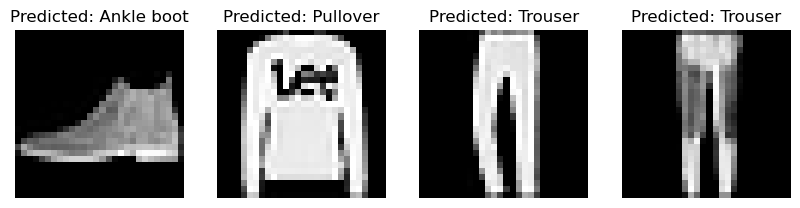

In [33]:
plt.figure(figsize=(10, 5))
for i in range(len(X_new)):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X_new[i], cmap="gray")
    plt.title(f"Predicted: {class_names[predicted_classes[i]]}")
    plt.axis("off")
plt.show()